### Training of modified U-Net for Optic Disc on RIM-ONE v3 database, 256 px images (cross-validation fold #0).

You can either train your model or upload a pre-trained one from:
*../models_weights/03.03,14:19,U-Net light, on RIM-ONE v3 256 px fold 0, SGD, high augm, CLAHE, log_dice loss/last_checkpoint.hdf5*.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
from datetime import datetime
#import warnings
#warnings.simplefilter('ignore')
import scipy as sp
import scipy.ndimage
import numpy as np
import pandas as pd
import skimage
import skimage.exposure
import mahotas as mh
from sklearn.cross_validation import KFold
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from tqdm import tqdm_notebook
from IPython.display import display
from dual_IDG import DualImageDataGenerator

/home/artem/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [3]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, \
    Convolution2D, MaxPooling2D, ZeroPadding2D, Input, Embedding, LSTM, merge, \
    Lambda, UpSampling2D, Deconvolution2D, Cropping2D
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [4]:
K.set_image_dim_ordering('th')

In [6]:
def mean_IOU_gpu(X, Y):
    """Computes mean Intersection-over-Union (IOU) for two arrays of binary images.
    Assuming X and Y are of shape (n_images, w, h)."""
    
    #X_fl = K.clip(K.batch_flatten(X), K.epsilon(), 1.)
    #Y_fl = K.clip(K.batch_flatten(Y), K.epsilon(), 1.)
    X_fl = K.clip(K.batch_flatten(X), 0., 1.)
    Y_fl = K.clip(K.batch_flatten(Y), 0., 1.)
    X_fl = K.cast(K.greater(X_fl, 0.5), 'float32')
    Y_fl = K.cast(K.greater(Y_fl, 0.5), 'float32')

    intersection = K.sum(X_fl * Y_fl, axis=1)
    union = K.sum(K.maximum(X_fl, Y_fl), axis=1)
    # if union == 0, it follows that intersection == 0 => score should be 0.
    union = K.switch(K.equal(union, 0), K.ones_like(union), union)
    return K.mean(intersection / K.cast(union, 'float32'))


def mean_IOU_gpu_loss(X, Y):
    return -mean_IOU_gpu(X, Y)

In [7]:
def dice(y_true, y_pred):
    # Workaround for shape bug. For some reason y_true shape was not being set correctly
    #y_true.set_shape(y_pred.get_shape())

    # Without K.clip, K.sum() behaves differently when compared to np.count_nonzero()
    #y_true_f = K.clip(K.batch_flatten(y_true), K.epsilon(), 1.)
    #y_pred_f = K.clip(K.batch_flatten(y_pred), K.epsilon(), 1.)
    y_true_f = K.clip(K.batch_flatten(y_true), 0., 1.)
    y_pred_f = K.clip(K.batch_flatten(y_pred), 0., 1.)
    #y_pred_f = K.greater(y_pred_f, 0.5)

    intersection = 2 * K.sum(y_true_f * y_pred_f, axis=1)
    union = K.sum(y_true_f * y_true_f, axis=1) + K.sum(y_pred_f * y_pred_f, axis=1)
    return K.mean(intersection / union)


def dice_loss(y_true, y_pred):
    return -dice(y_true, y_pred)


def log_dice_loss(y_true, y_pred):
    return -K.log(dice(y_true, y_pred))


def dice_metric(y_true, y_pred):
    """An exact Dice score for binary tensors."""
    y_true_f = K.cast(K.greater(y_true, 0.5), 'float32')
    y_pred_f = K.cast(K.greater(y_pred, 0.5), 'float32')
    return dice(y_true_f, y_pred_f)

In [9]:
def tf_to_th_encoding(X):
    return np.rollaxis(X, 3, 1)


def th_to_tf_encoding(X):
    return np.rollaxis(X, 1, 4)

In [11]:
h5f = h5py.File("../data/hdf5_datasets/all_data.hdf5", "r")

#h5f = h5py.File("../data/hdf5_datasets/RIM_ONE_v3.hdf5", "r")

### U-Net architecture

<img src="../pics/u_net_arch.png" width=80%>

In [12]:
def get_unet_light(img_rows=256, img_cols=256):
    inputs = Input((3, img_rows, img_cols))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Dropout(0.3)(conv1)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Dropout(0.3)(conv2)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Dropout(0.3)(conv3)
    conv3 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Dropout(0.3)(conv4)
    conv4 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Dropout(0.3)(conv5)
    conv5 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Dropout(0.3)(conv6)
    conv6 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Dropout(0.3)(conv7)
    conv7 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Dropout(0.3)(conv8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Dropout(0.3)(conv9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid', border_mode='same')(conv9)
    #conv10 = Flatten()(conv10)

    model = Model(input=inputs, output=conv10)

    return model

In [13]:
model = get_unet_light(img_rows=256, img_cols=256)
model.compile(optimizer=SGD(lr=1e-3, momentum=0.95),
              loss=log_dice_loss,
              metrics=[mean_IOU_gpu, dice_metric])

model.summary()

/home/artem/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/artem/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  """
/home/artem/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  
/home/artem/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
/home/artem/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: UserWarning: 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 256, 256)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 256, 256) 896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 32, 256, 256) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 256, 256) 9248        dropout_1[0][0]                  
__________________________________________________________________________________________________
max_poolin

#### RIM-ONE v3

Accessing data, preparing train/validation sets division:

In [14]:
X = h5f['RIM-ONE v3/256 px/images']
Y = h5f['RIM-ONE v3/256 px/disc']

In [15]:
X, Y

(<HDF5 dataset "images": shape (159, 256, 256, 3), type "|u1">,
 <HDF5 dataset "disc": shape (159, 256, 256, 1), type "|u1">)

In [16]:
train_idx_cv, test_idx_cv = [], []

for _train_idx, _test_idx in KFold(len(X), n_folds=5, random_state=1):
    print(_train_idx, _test_idx)
    train_idx_cv.append(_train_idx)
    test_idx_cv.append(_test_idx)

(array([ 32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
        45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
       136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
       149, 150, 151, 152, 153, 154, 155, 156, 157, 158]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]))
(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
   

In [17]:
#train_idx = h5f['RIM-ONE v3/train_idx_driu']
#test_idx = h5f['RIM-ONE v3/test_idx_driu']

train_idx = train_idx_cv[0]
test_idx = test_idx_cv[0]

In [18]:
len(X), len(train_idx), len(test_idx)

(159, 127, 32)

#### Generator of augmented data:

In [19]:
train_idg = DualImageDataGenerator(#rescale=1/255.0,
                                   #samplewise_center=True, samplewise_std_normalization=True,
                                   horizontal_flip=True, vertical_flip=True,
                                   rotation_range=50, width_shift_range=0.15, height_shift_range=0.15,
                                   zoom_range=(0.7, 1.3),
                                   fill_mode='constant', cval=0.0)
test_idg = DualImageDataGenerator()

#### Preprocessing function and data generator:

In [20]:
def preprocess(batch_X, batch_y, train_or_test='train'):
    batch_X = batch_X / 255.0
    batch_y = batch_y / 255.0
    if train_or_test == 'train':
        batch_X, batch_y = train_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False).next()
    elif train_or_test == 'test':
        batch_X, batch_y = test_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False).next()
    batch_X = th_to_tf_encoding(batch_X)
    batch_X = [skimage.exposure.equalize_adapthist(batch_X[i]) 
               for i in range(len(batch_X))]
    batch_X = np.array(batch_X)
    batch_X = tf_to_th_encoding(batch_X)
    return batch_X, batch_y


def data_generator(X, y, train_or_test='train', batch_size=3, return_orig=False, stationary=False):    
    while True:
        if train_or_test == 'train':
            idx = np.random.choice(train_idx, size=batch_size)
        elif train_or_test == 'test':
            if stationary:
                idx = test_idx[:batch_size]
            else:
                idx = np.random.choice(test_idx, size=batch_size)
        batch_X = [X[i] for i in idx]
        batch_X = np.array(batch_X).copy()
        batch_y = [y[i] for i in idx]
        batch_y = np.array(batch_y).copy()
        batch_X = tf_to_th_encoding(batch_X)
        batch_y = tf_to_th_encoding(batch_y)
        if return_orig:
            batch_X_orig, batch_Y_orig = batch_X.copy(), batch_y.copy()
        
        batch_X, batch_y = preprocess(batch_X, batch_y, train_or_test)
        
        if not return_orig:
            yield batch_X, batch_y
        else:
            yield batch_X, batch_y, batch_X_orig, batch_Y_orig

Testing the data generator and generator for augmented data:

In [21]:
gen = data_generator(X, Y, 'train', batch_size=1)
batch = gen.next()
batch[0].shape

/home/artem/.local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


(1, 3, 256, 256)

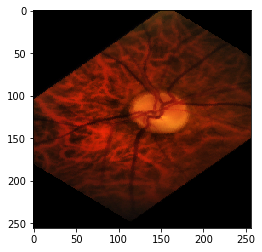

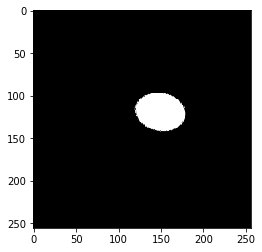

In [22]:
fig = plt.imshow(np.rollaxis(batch[0][0], 0, 3))
#plt.colorbar(mappable=fig)
plt.show()
plt.imshow(batch[1][0][0], cmap=plt.cm.Greys_r); plt.show()

In [23]:
arch_name = "U-Net light, on RIM-ONE v3 256 px fold 0, SGD, high augm, CLAHE, log_dice loss"
weights_folder = '../models_weights/' \
                 '{},{}/'.format(datetime.now().strftime('%d.%m,%H:%M'), arch_name)

In [24]:
weights_folder

'../models_weights/02.01,15:30,U-Net light, on RIM-ONE v3 256 px fold 0, SGD, high augm, CLAHE, log_dice loss/'

In [25]:
def folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    return folder_name

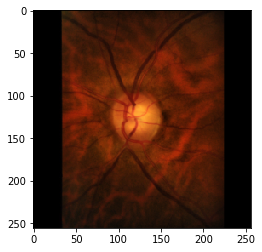

((32, 3, 256, 256), (32, 1, 256, 256))


In [26]:
X_valid, Y_valid = data_generator(X, Y, train_or_test='test', batch_size=100, stationary=True).next()
plt.imshow(np.rollaxis(X_valid[0], 0, 3)); plt.show()
print(X_valid.shape, Y_valid.shape)

### Training

If a pretrained model needs to be used, first run "Loading model" section below and then go the "Comprehensive visual check", skipping this section.

In [ ]:
history = model.fit_generator(data_generator(X, Y, train_or_test='train', batch_size=1), 
                              samples_per_epoch=99,
                              max_q_size=1,
                              
                              validation_data=(X_valid, Y_valid),
                              #validation_data=data_generator(X, Y, train_or_test='test', batch_size=1),
                              #nb_val_samples=100,
                              
                              nb_epoch=500, verbose=1,
                              
                              callbacks=[CSVLogger(folder(weights_folder) + '/' + 'training_log.csv'),
                                         ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5, verbose=1, patience=40),
                                         ModelCheckpoint(folder(weights_folder) + '/' + \
                                               #'weights.ep-{epoch:02d}-val_mean_IOU-{val_mean_IOU_gpu:.2f}_val_loss_{val_loss:.2f}.hdf5',
                                               'last_checkpoint.hdf5',
                                               monitor='val_loss', mode='min', save_best_only=True, 
                                               save_weights_only=False, verbose=0)])

### Comprehensive visual check

image #0


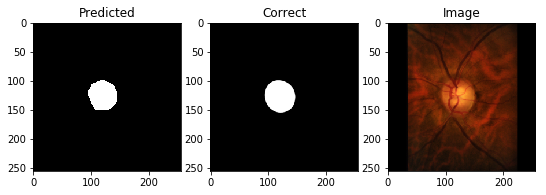

IOU: 0.881618618965
Dice: 0.944140385556
image #1


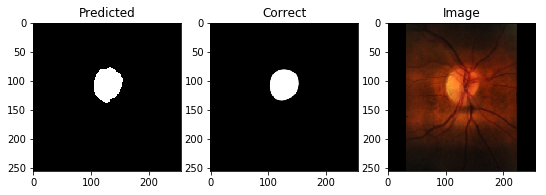

IOU: 0.896165430546
Dice: 0.952512119605
image #2


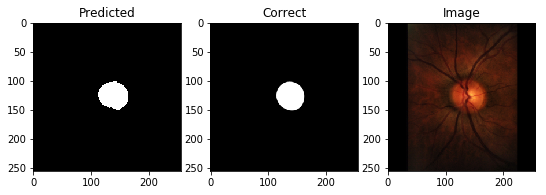

IOU: 0.901590466499
Dice: 0.955338500336
image #3


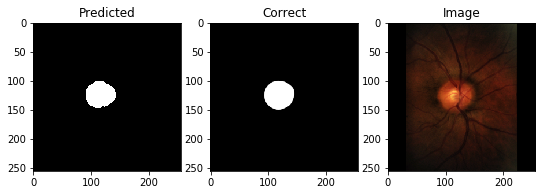

IOU: 0.817249417305
Dice: 0.908342094177
image #4


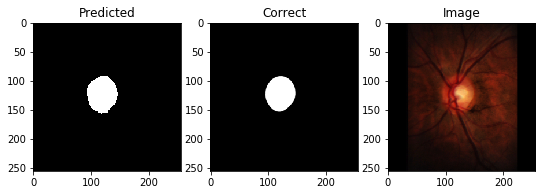

IOU: 0.889970064163
Dice: 0.949202932229
image #5


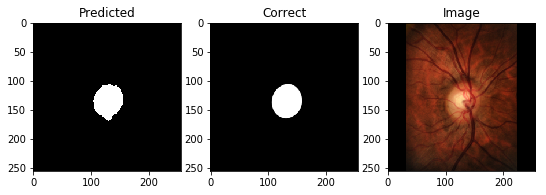

IOU: 0.858206033707
Dice: 0.930079321709
image #6


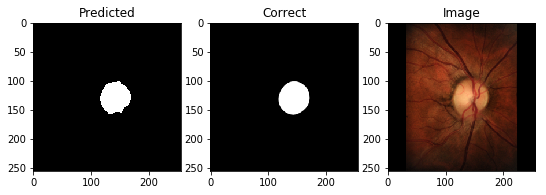

IOU: 0.831353902817
Dice: 0.915274571038
image #7


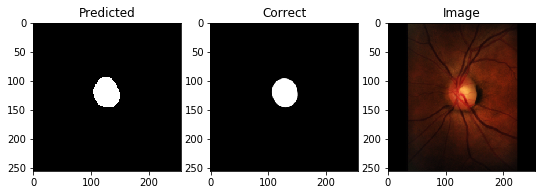

IOU: 0.852156043053
Dice: 0.928918368497
image #8


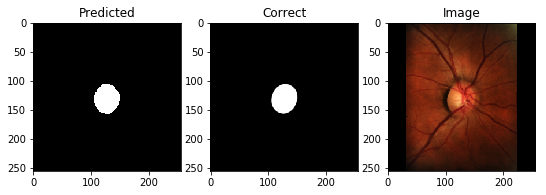

IOU: 0.936205029488
Dice: 0.971991061815
image #9


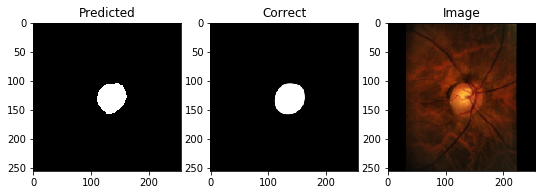

IOU: 0.866203308105
Dice: 0.937538412762
image #10


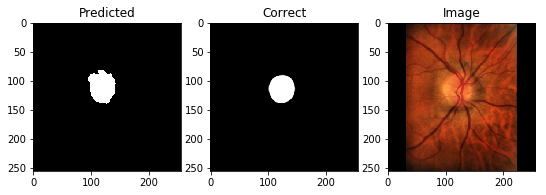

IOU: 0.716167092323
Dice: 0.841283003187
image #11


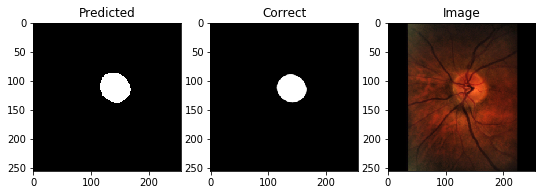

IOU: 0.876048445702
Dice: 0.94081587722
image #12


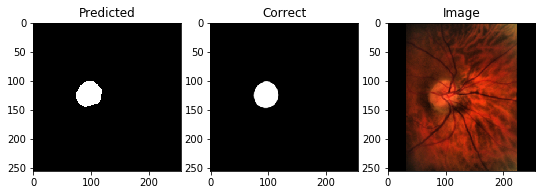

IOU: 0.902058660984
Dice: 0.956256105022
image #13


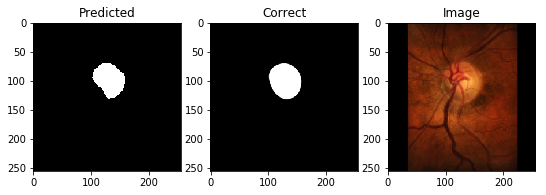

IOU: 0.864636838436
Dice: 0.933818097387
image #14


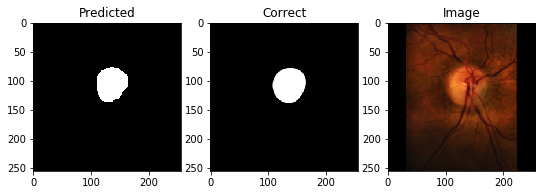

IOU: 0.889405846596
Dice: 0.947789527596
image #15


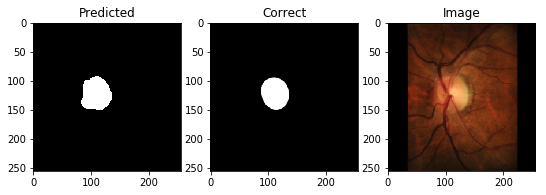

IOU: 0.826596617699
Dice: 0.911744908846
image #16


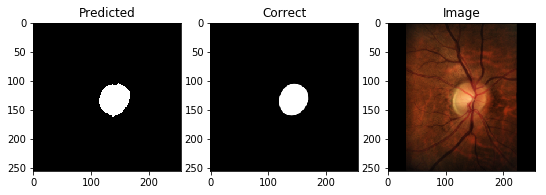

IOU: 0.83590811491
Dice: 0.918047823649
image #17


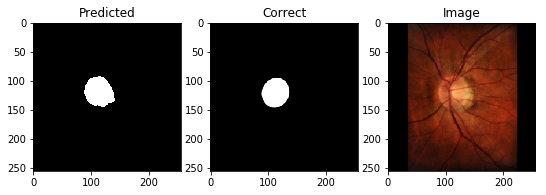

IOU: 0.83757519722
Dice: 0.919305203472
image #18


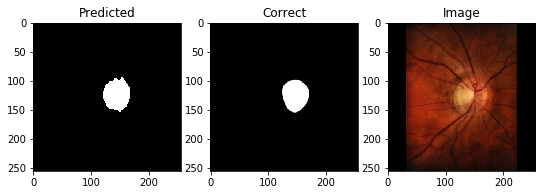

IOU: 0.822162628174
Dice: 0.909941482608
image #19


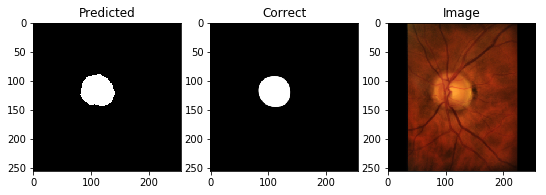

IOU: 0.890097081661
Dice: 0.948022032786
image #20


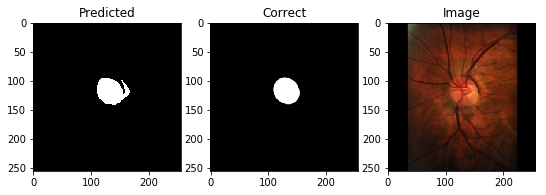

IOU: 0.835269272327
Dice: 0.914823377471
image #21


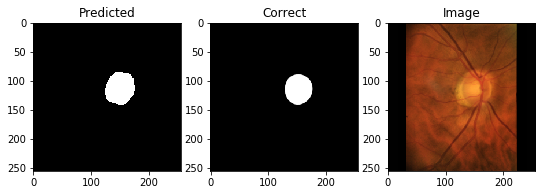

IOU: 0.808393359184
Dice: 0.90028221362
image #22


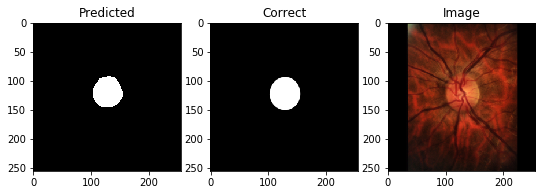

IOU: 0.882621347904
Dice: 0.944893051227
image #23


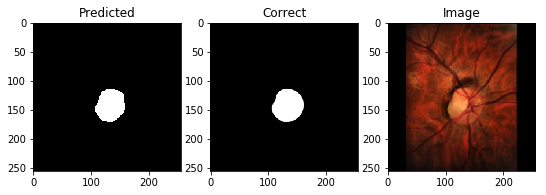

IOU: 0.925819694996
Dice: 0.967024308317
image #24


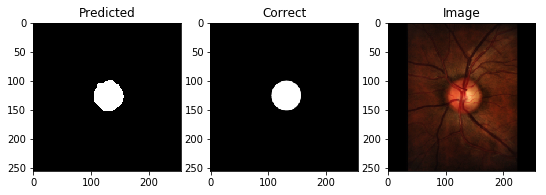

IOU: 0.906860530376
Dice: 0.959571945249
image #25


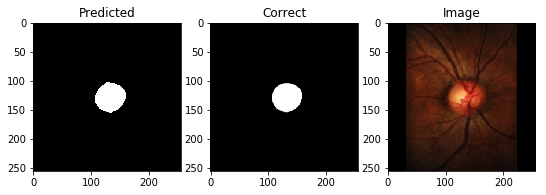

IOU: 0.938938498497
Dice: 0.974097883395
image #26


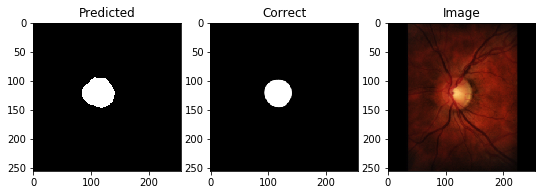

IOU: 0.776841163635
Dice: 0.880669597062
image #27


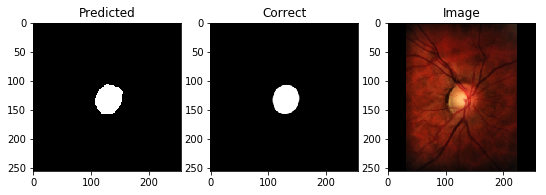

IOU: 0.931912660599
Dice: 0.971821053302
image #28


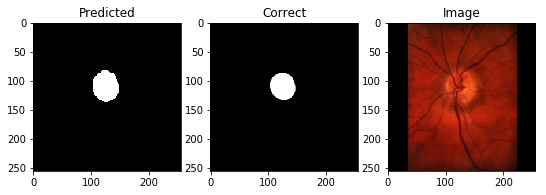

IOU: 0.844513773918
Dice: 0.923892559624
image #29


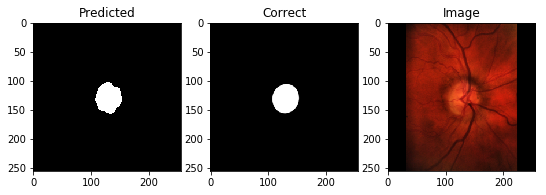

IOU: 0.915800392628
Dice: 0.962504904047
image #30


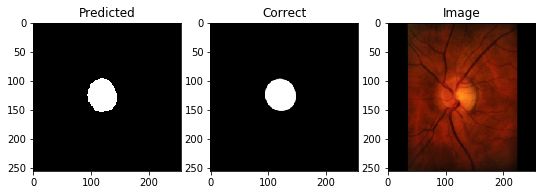

IOU: 0.882761418819
Dice: 0.945957516274
image #31


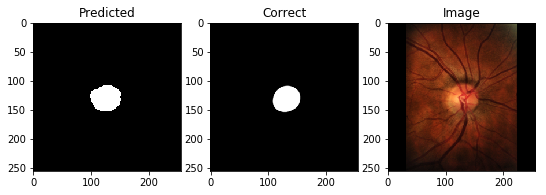

IOU: 0.735294103622
Dice: 0.855248670805


In [29]:
pred_iou, pred_dice = [], []

if K.backend() == 'tensorflow':
    sess = K.get_session()

for i, img_no in enumerate(test_idx):
    print('image #{}'.format(img_no))
    img = X[img_no]
    batch_X = X_valid[i:i + 1]
    batch_y = Y_valid[i:i + 1]
    
    pred = (model.predict(batch_X)[0, 0] > 0.5).astype(np.float64)
    #corr = Y[img_no][..., 0]
    corr = th_to_tf_encoding(batch_y)[0, ..., 0]
    
    # mean filtering:
    #pred = mh.mean_filter(pred, Bc=mh.disk(10)) > 0.5
    
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    #ax.imshow(img)
    ax.imshow(th_to_tf_encoding(batch_X)[0])
    ax.set_title('Image')
    plt.show()
    
    if K.backend() == 'tensorflow':
        cur_iou = mean_IOU_gpu(pred[None, None, ...], corr[None, None, ...]).eval(session=sess)
        cur_dice = dice(pred[None, None, ...], corr[None, None, ...]).eval(session=sess)
    else:
        cur_iou = mean_IOU_gpu(pred[None, None, ...], corr[None, None, ...]).eval()
        cur_dice = dice(pred[None, None, ...], corr[None, None, ...]).eval()
    print('IOU: {}\nDice: {}'.format(cur_iou, cur_dice))
    pred_iou.append(cur_iou)
    pred_dice.append(cur_dice)

Acquiring scores for the validation set:

In [30]:
print(np.mean(pred_iou))
print(np.mean(pred_dice))

0.861763
0.931910903434


Showing the best and the worst cases:

/home/ubuntu/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


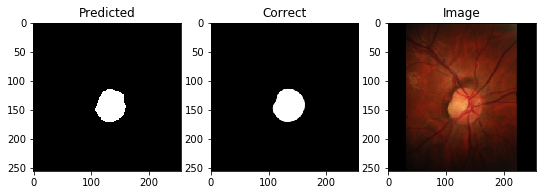

IOU: 0.9331958889961243, Dice: 0.9721364573581157 (best)


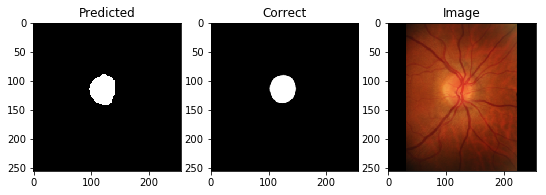

IOU: 0.7989898920059204, Dice: 0.8960907109713492 (worst)


In [55]:
def show_img_pred_corr(i, file_suffix):    # i is index of image in test_idx
    img_no = test_idx[i]
    batch_X = X[img_no:img_no + 1]
    batch_X = tf_to_th_encoding(batch_X)
    batch_y = Y[img_no:img_no + 1]
    batch_y = tf_to_th_encoding(batch_y)
    batch_X, batch_y = preprocess(batch_X, batch_y, 'test')
    
    pred = model.predict(batch_X)[0, 0] > 0.5
    #corr = Y[img_no][..., 0]
    corr = th_to_tf_encoding(batch_y)[0, ..., 0]
    
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    #ax.imshow(img)
    ax.imshow(X[img_no])
    ax.set_title('Image')
    plt.show()
    
    plt.imsave('od_rim_one_v3_fold_0_{}_case_image.png'.format(file_suffix), X[img_no])
    plt.imsave('od_rim_one_v3_fold_0_{}_case_pred.png'.format(file_suffix), pred, cmap=plt.cm.Greys_r)
    plt.imsave('od_rim_one_v3_fold_0_{}_case_corr.png'.format(file_suffix), corr, cmap=plt.cm.Greys_r)


best_idx = np.argmax(pred_iou)
worst_idx = np.argmin(pred_iou)
show_img_pred_corr(best_idx, 'best')
print('IOU: {}, Dice: {} (best)'.format(pred_iou[best_idx], pred_dice[best_idx]))
show_img_pred_corr(worst_idx, 'worst')
print('IOU: {}, Dice: {} (worst)'.format(pred_iou[worst_idx], pred_dice[worst_idx]))

### Loading model

In [27]:
load_model = True   # lock
if not load_model:
    print('load_model == False')
else:
    # UNCOMMENT APPROPRIATE LINE(S) BELOW:
    # specify file:
    #model_path = '../models_weights/01.11,22:38,U-Net on DRIONS-DB 256 px, Adam, augm, log_dice loss/' \
    #    'weights.ep-20-val_mean_IOU-0.81_val_loss_0.08.hdf5'
    # or get the most recently altered file in a folder:
    model_folder = '../models_weights/03.03,14_19,U-Net light, on RIM-ONE v3 256 px fold 0, SGD, high augm, CLAHE, log_dice loss/'
    
    model_path = max(glob.glob(os.path.join(model_folder, '*.hdf5')), key=os.path.getctime)
    if load_model and not os.path.exists(model_path):
        raise Exception('`model_path` does not exist')
    print('Loading weights from', model_path)

    if load_model:
        #with open(model_path + ' arch.json') as arch_file:
        #    json_string = arch_file.read()
        #new_model = model_from_json(json_string)
        model.load_weights(model_path)
    
    # Reading log statistics
    import pandas as pd
    
    log_path = os.path.join(model_folder, 'training_log.csv')
    if os.path.exists(log_path):
        log = pd.read_csv(log_path)
        if log['epoch'].dtype != 'int64':
            log = log.loc[log.epoch != 'epoch']
        print('\nmax val mean IOU: {}, at row:'.format(log['val_mean_IOU_gpu'].max()))
        print(log.loc[log['val_mean_IOU_gpu'].argmax()])
        if 'val_dice_metric' in log.columns:
            print('\n' + 'max val dice_metric: {}, at row:'.format(log['val_dice_metric'].max()))
            print(log.loc[log['val_dice_metric'].argmax()])
        if 'val_dice' in log.columns:
            print('\n' + 'max val dice: {}, at row:'.format(log['val_dice'].max()))
            print(log.loc[log['val_dice'].argmax()])

('Loading weights from', '../models_weights/03.03,14_19,U-Net light, on RIM-ONE v3 256 px fold 0, SGD, high augm, CLAHE, log_dice loss/last_checkpoint.hdf5')

max val mean IOU: 0.880920009688, at row:
epoch               196.000000
dice_metric           0.902209
loss                  0.071331
mean_IOU_gpu          0.826438
val_dice_metric       0.936309
val_loss              0.042184
val_mean_IOU_gpu      0.880920
Name: 196, dtype: float64

max val dice_metric: 0.936309117824, at row:
epoch               196.000000
dice_metric           0.902209
loss                  0.071331
mean_IOU_gpu          0.826438
val_dice_metric       0.936309
val_loss              0.042184
val_mean_IOU_gpu      0.880920
Name: 196, dtype: float64
